In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import json
import mrcfile
import umap

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors
from cryo_sbi.utils.estimator_utils import sample_posterior, compute_latent_repr
from cryo_sbi.utils.image_utils import (
    LowPassFilter,
    NormalizeIndividual,
    MRCtoTensor,
    FourierDownSample,
    Mask,
)

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class WhitenImage:
    def __init__(self, noise_psd):
        self.noise_psd = noise_psd

    def __call__(self, image):
        fft_image = torch.fft.fft2(image)
        fft_image = fft_image / torch.sqrt(self.noise_psd)
        reconstructed = torch.fft.ifft2(fft_image).real
        return reconstructed

In [3]:
transform = transforms.Compose(
    [
        MRCtoTensor(),
        transforms.Resize(size=(128, 128)),
        NormalizeIndividual(),
        Mask(128, 30),
    ]
)

transform_sim = transforms.Compose(
    [NormalizeIndividual(), Mask(128, 50), LowPassFilter(128, 80)]
)

transform_exp = transforms.Compose(
    [
        MRCtoTensor(),
        transforms.Resize(size=(128, 128)),
        NormalizeIndividual(),
        # Mask(128, 45),
        # LowPassFilter(128, 80)
    ]
)

In [4]:
file_name = "6wxb_nma"  # File name
data_dir = "../experiments/6wxb/"
num_samples_stats = 20000  # Number of simulations for computing posterior stats
num_samples_SBC = 10000  # Number of simulations for SBC
num_posterior_samples_SBC = 4096  # Number of posterior samples for each SBC simulation
num_samples_posterior = 50000  # Number of samples to draw from posterior
batch_size_sampling = 100  # Batch size for sampling posterior
num_workers = 24  # Number of CPU cores
device = "cuda"  # Device for computations
save_figures = False

## Load cryo-em simulator and posterior with correct config

In [5]:
cryosbi = CryoEmSimulator(data_dir + "image_params_torsion_training.json")

../data/protein_models/6wxb_torsion_models.npy


In [6]:
cryosbi.config["SNR"] = 0.5
cryosbi.config["NOISE"] = True
cryosbi.config["SIGMA"] = 2.0
cryosbi.config["DEFOCUS"] = 2.5
cryosbi.rot_mode = False  # "random"
cryosbi.config["SHIFT"] = False

In [77]:
train_config = json.load(open(data_dir + "resnet18_fft_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(data_dir + "whitening_posterior.estimator"))
estimator.cuda()
estimator.eval();

# Test simulator over whole prior range

In [7]:
# %%timeit
indices = torch.tensor(np.arange(0, 100, 5, dtype=float))  #
# indices = 50 * torch.ones((100,), dtype=torch.float)  #
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [25]:
filter = Mask(128, 60)
images = filter(images)

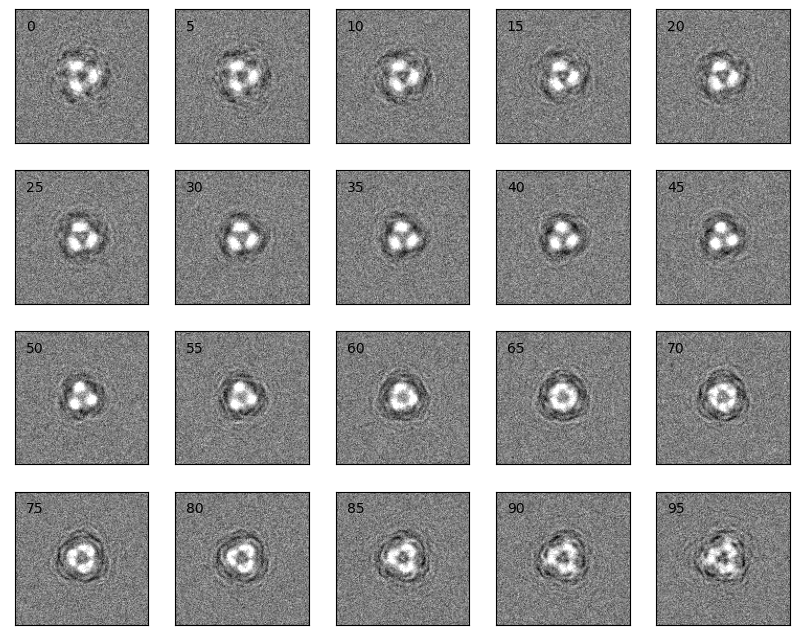

In [8]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[idx], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(10, 20, str(int(indices[idx].item())))
# plt.savefig('fitted_noise.pdf', dpi=500)

In [ ]:
with m

In [19]:
def image_psd(image):
    image_fft = torch.fft.fftshift(torch.fft.fft2(image))
    image_psd = torch.abs(image_fft) ** 2
    return image_psd

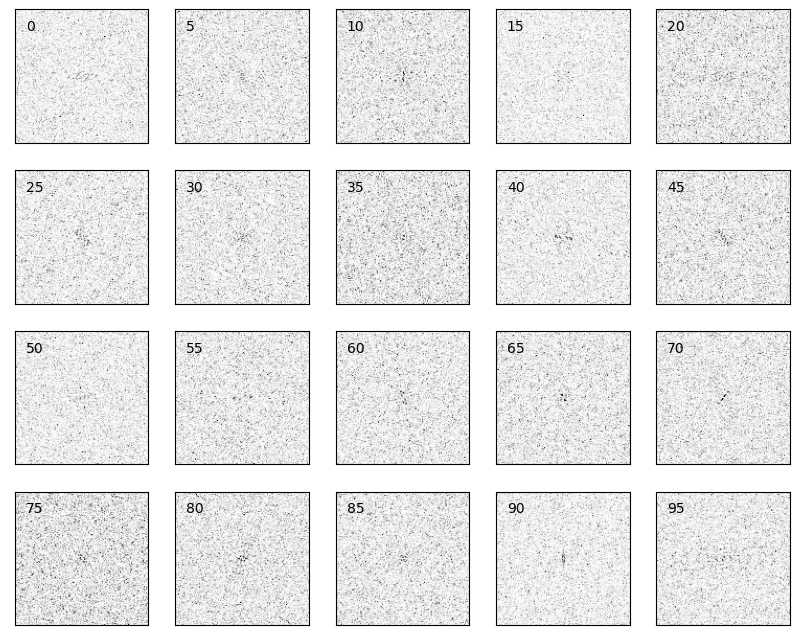

In [20]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(image_psd(images[idx]), cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(10, 20, str(int(indices[idx].item())))

In [21]:
samples = sample_posterior(estimator, images, num_samples=10000, device="cuda")

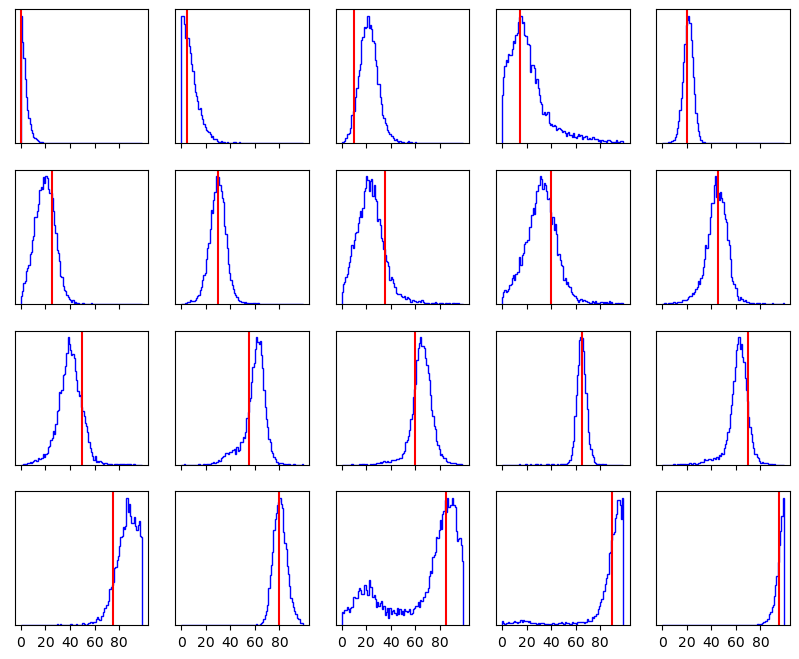

In [22]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples[:, idx].flatten().numpy(),
        bins=np.arange(0, 100, 1),
        histtype="step",
        color="blue",
        label="all",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))
    ax.axvline(indices[idx], color="red")
# plt.savefig('../experiments/6wxb/results/plots/torsion_nma.pdf', dpi=300)

## BioEM generated particles

In [ ]:
bioEM_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        FourierDownSample(256, 128),
        NormalizeIndividual(),
        # Mask(128, 15),
        # LowPassFilter(128, 80),
    ]
)

In [ ]:
bioEM_names = [
    "bioEM-map-m47-im7",
    "bioEM-map-m44-im3",
    "bioEM-map-m42-im1",
    "bioEM-map-m37-im2",
]
bioEM_images = []
for name in bioEM_names:
    bioEM_images.append(
        bioEM_transform(
            np.genfromtxt(f"../../6wxb/particles/BioEM_results/BioEM_results/{name}")[
                :, 2
            ].reshape((256, 256))
        )
    )
bioEM_images = torch.cat(bioEM_images, dim=0).to(torch.float32)

In [ ]:
samples_bioEM = sample_posterior(
    estimator, bioEM_images, num_samples=100000, device="cuda"
)

In [ ]:
_ = plt.hist(
    samples_bioEM[:, 0].flatten(),
    bins=np.arange(0, 100, 1),
    histtype="step",
    color="blue",
    label="all",
)

In [ ]:
cryosbi = CryoEmSimulator(data_dir + "image_params_mixed_training.json")
cryosbi.config["SNR"] = 0.012
cryosbi.config["SIGMA"] = 0.9
cryosbi.config["DEFOCUS"] = 2.5
cryosbi.config["SHIFT"] = False
cryosbi.rot_mode = None

indices = torch.tensor(
    [47, 44, 42, 37], dtype=torch.float
)  # torch.tensor(np.arange(0, 100, 5, dtype=float))
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [ ]:
transform_e = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        WhitenImage(torch.load("noise_psd.pt")),
        NormalizeIndividual(),
        Mask(128, 45),
    ]
)

transform_s = transforms.Compose(
    [
        NormalizeIndividual(),
    ]
)

In [ ]:
img_file = "../../6wxb/particles/bio_em_images.mrc"
exp_particles = transform_e(img_file)
images = transform_s(images)

In [ ]:
idx_images = torch.tensor([3, 10, 1, 2])
fig, axes = plt.subplots(3, 4, figsize=(15, 9), sharex=True)

for i, ax in enumerate(axes[2]):
    ax.imshow(images[i], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_yticks([])

for i, ax in enumerate(axes[1]):
    ax.imshow(bioEM_images[i], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_yticks([])

for i, ax in enumerate(axes[0]):
    ax.imshow(exp_particles[idx_images[i]], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks([])
# plt.savefig('image_comparison_new_noise_lpf.pdf', dpi=500)

In [ ]:
images_combined = torch.cat([images, bioEM_images, exp_particles[idx_images]], dim=0)

In [ ]:
transform_comparison = transforms.Compose(
    [
        # Mask(128, 60),
        # LowPassFilter(128, 80),
    ]
)

In [ ]:
samples_combined = sample_posterior(
    estimator, transform_comparison(images_combined), num_samples=100000, device="cuda"
)

In [ ]:
indices = torch.tensor([47, 44, 42, 37], dtype=torch.float)
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True)

for i, ax in enumerate(axes):
    print(i + 4)
    ax.hist(
        samples_combined[:, i].flatten().numpy(),
        bins=np.arange(0, 100, 0.7),
        histtype="step",
        color="blue",
        label="CryoSBI",
    )
    ax.hist(
        samples_combined[:, i + 4].flatten().numpy(),
        bins=np.arange(0, 100, 0.7),
        histtype="step",
        color="red",
        label="BioEM",
    )
    ax.hist(
        samples_combined[:, i + 8].flatten().numpy(),
        bins=np.arange(0, 100, 0.7),
        histtype="step",
        color="green",
        label="Exper.",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 101, 20))
    ax.axvline(indices[i], color="red")
ax.legend()
# plt.savefig(
#    "../experiments/6wxb/results/plots/particle_posterior_comparison_20px_mask.pdf",
#    dpi=500,
# )

# Now with real data

In [150]:
final_size = 128
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, final_size),
        # transforms.Resize(size=(128, 128)),
        WhitenImage(torch.load("noise_psd.pt")),
        NormalizeIndividual(),
        Mask(final_size, 50),
        # LowPassFilter(final_size, 80),
        # NormalizeIndividual(),
    ]
)

In [151]:
particles_transfomed = []
for i in range(1, 50):
    if i < 10:
        img_file = f"../../6wxb/particles/particles_0{i}.mrc"
    else:
        img_file = f"../../6wxb/particles/particles_{i}.mrc"
    tmp_images = transform(img_file)
    particles_transfomed.append(tmp_images)
particles_transfomed = torch.cat(particles_transfomed, dim=0)

In [ ]:
img_file = "../../6wxb/particles/template_matched_image/picked-particles.mrcs"
particles_transfomed = transform(img_file)

In [68]:
img_file = "../../6wxb/particles/bio_em_images.mrc"
particles_transfomed = transform(img_file)
# particles_transfomed[:, cm] = 0

In [152]:
img_file = [
    "../../6wxb/cross_corr/2DTM_1/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_10/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_7/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_8/picked-particles.mrc",
    "../../6wxb/cross_corr/2DTM_9/picked-particles.mrc",
]
particles_transfomed = []
for path in img_file:
    tmp_parts = transform(path)
    particles_transfomed.append(tmp_parts)
particles_transfomed = torch.cat(particles_transfomed, dim=0)

In [153]:
samples_real = sample_posterior(
    estimator, particles_transfomed, num_samples=10000, device="cuda", batch_size=1000
)

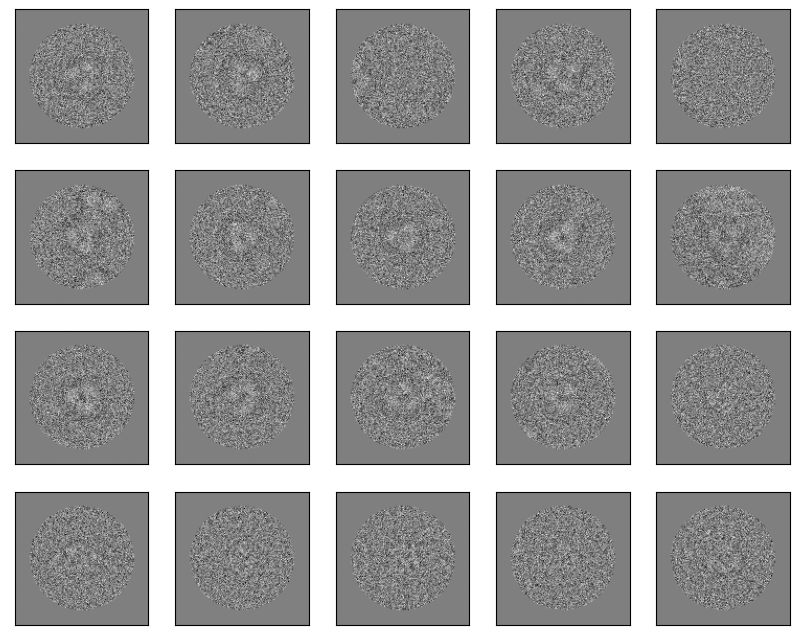

In [163]:
offset = 20
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(particles_transfomed[i + offset], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])
# fig.savefig('../experiments/6wxb/results/plots/real_particles_bioEM.pdf', dpi=500)

NameError: name 'image_psd' is not defined

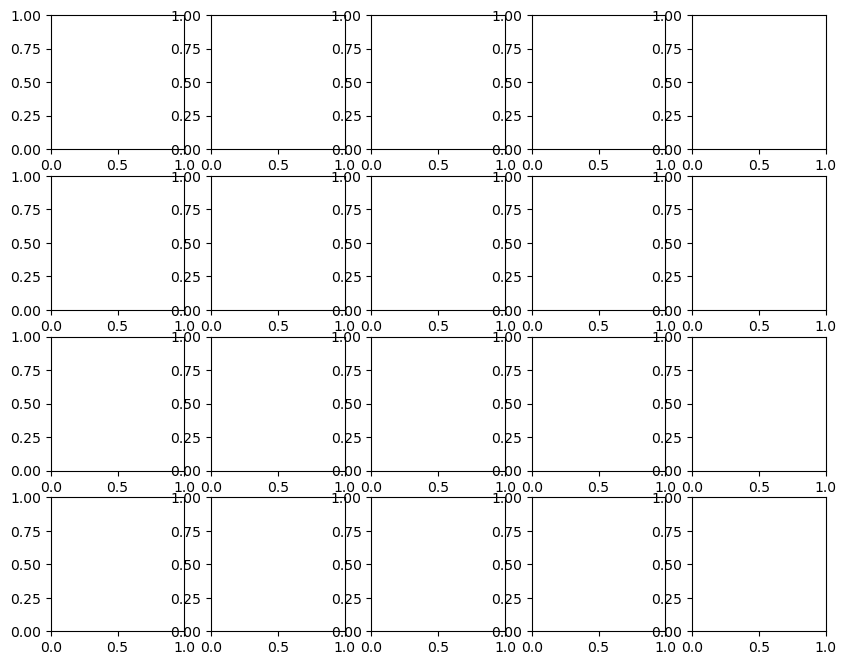

In [164]:
offset = 0
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(image_psd(particles_transfomed[i + offset]), cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])

In [165]:
# fig ,axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)
# axes[0].imshow(particles_transfomed[0], vmax=4, vmin=-4, cmap='binary')
# axes[1].imshow(images[10], vmax=4, vmin=-4, cmap='binary')

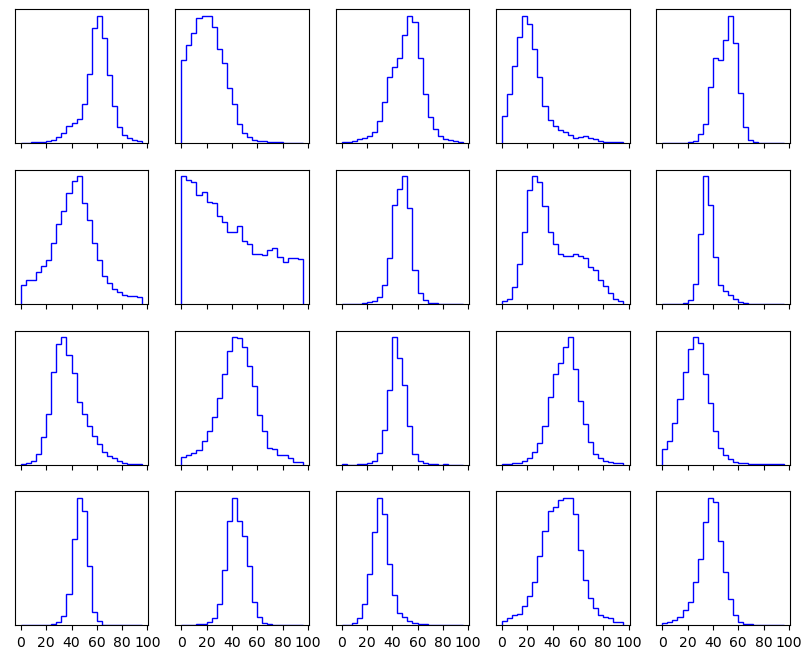

In [166]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for i, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples_real[:, i + offset].flatten().numpy(),
        bins=np.arange(0, 100, 4),
        histtype="step",
        color="blue",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 101, 20))
    # ax.axvline(50, color='red')
# axes[0, 0].legend(bbox_to_anchor=(1.3, 1.5), loc="upper center", ncol=3)
# fig.savefig('different_posteriors.pdf', dpi=500)

In [159]:
means = samples_real.mean(axis=0)
posterior_quantiles = np.quantile(samples_real.numpy(), [0.025, 1 - 0.025], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

In [144]:
bioEM_map_posterior = torch.load(
    "/home/dingeldein/Desktop/6wxb/particles/map_posteriors.pt"
)

([], [])

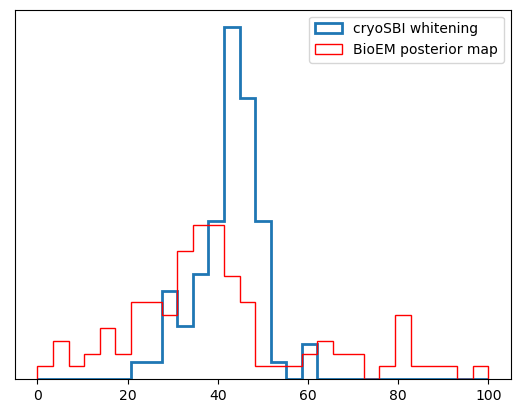

In [146]:
plt.hist(
    samples_real.mean(axis=0),
    bins=np.linspace(0, 100, 30),
    density=True,
    label="cryoSBI whitening",
    histtype="step",
    linewidth=2,
)
plt.hist(
    bioEM_map_posterior,
    bins=np.linspace(0, 100, 30),
    histtype="step",
    color="red",
    density=True,
    label="BioEM posterior map",
)
xticks = np.load("../../6wxb/6wxb_nma/distance_to_reference.npy")
# plt.xlabel('Position of posterior means (RMSD)', fontsize=15)
# plt.xticks(ticks=[0, 20, 40, 60, 80, 100], labels=list(map(lambda x: f'{x:.3f}', xticks[::20])))
plt.legend()
plt.yticks([])
# plt.ylim(0, 0.05)

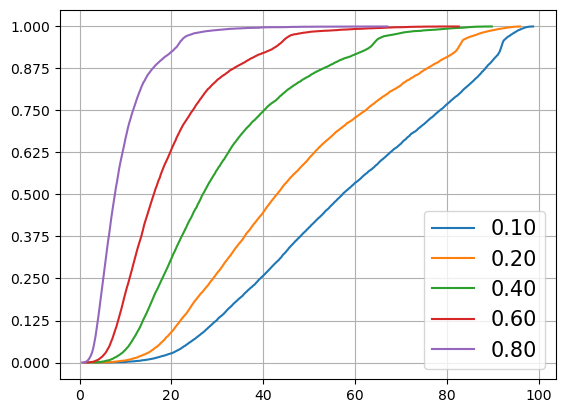

In [32]:
for alpha in [0.05, 0.1, 0.2, 0.3, 0.4]:
    posterior_quantiles = np.quantile(samples_real.numpy(), [alpha, 1 - alpha], axis=0)
    confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()
    counts, bins = np.histogram(confidence_widths, bins=1000, density=True)
    cum_counts = np.cumsum(counts) / np.sum(counts)
    plt.plot(bins[1:], cum_counts, label=f"{2*alpha:.2f}")

plt.yticks(np.linspace(0, 1, 9))
plt.legend(fontsize=15)
plt.grid()

In [64]:
posterior_quantiles = np.quantile(samples_real.numpy(), [0.025, 1 - 0.025], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()
condition = confidence_widths < 25
idx = np.where(condition)[0]
len(idx)

293

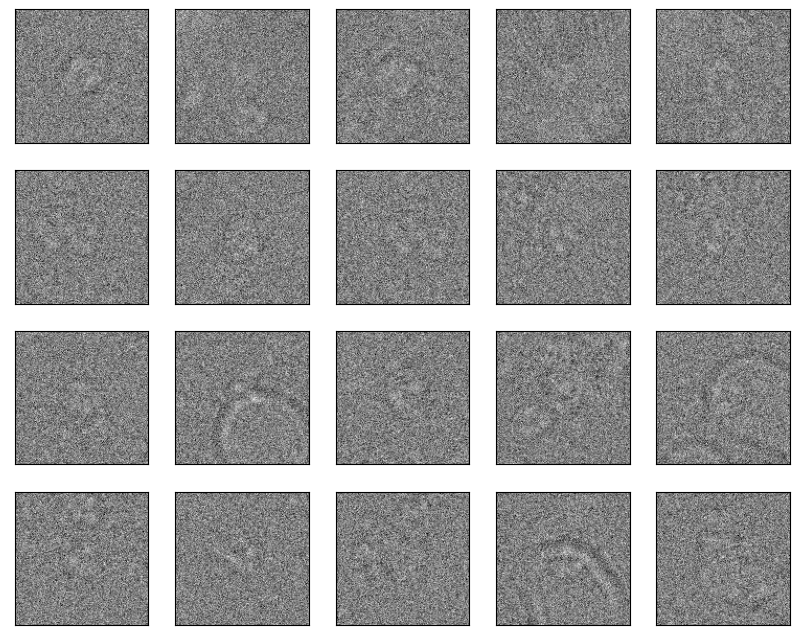

In [65]:
offset = 20
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(particles_transfomed[idx[i + offset]], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])

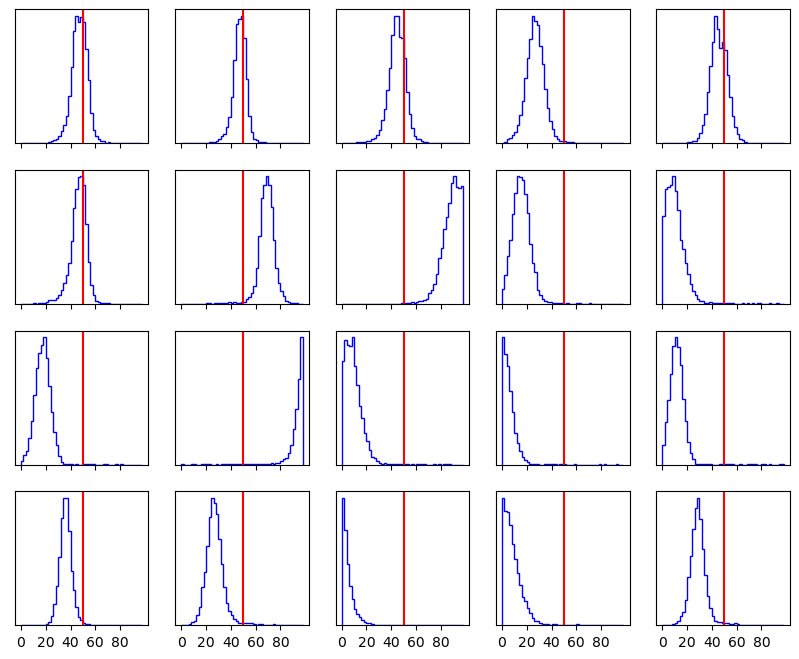

In [63]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for i, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples_real[:, idx[i + offset]].flatten().numpy(),
        bins=np.arange(0, 100, 2),
        histtype="step",
        color="blue",
        label="all",
    )
    ax.axvline(50, color="red")
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))

([], [])

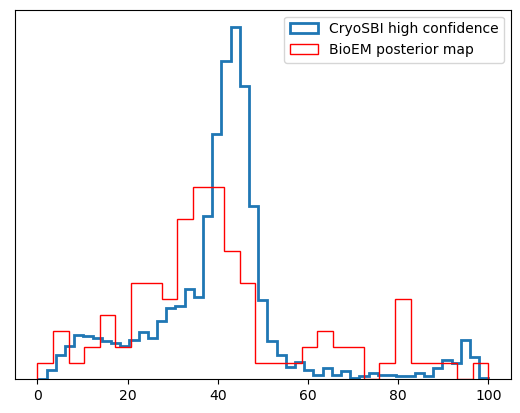

In [60]:
plt.hist(
    samples_real[:, idx].mean(axis=0),
    bins=np.linspace(0, 100, 50),
    density=True,
    label="CryoSBI high confidence",
    histtype="step",
    linewidth=2,
)
plt.hist(
    bioEM_map_posterior,
    bins=np.linspace(0, 100, 30),
    histtype="step",
    color="red",
    density=True,
    label="BioEM posterior map",
)
xticks = np.load("../../6wxb/6wxb_nma/distance_to_reference.npy")
# plt.xlabel('Position of posterior means (RMSD)', fontsize=15)
# plt.xticks(ticks=[0, 20, 40, 60, 80, 100], labels=list(map(lambda x: f'{x:.3f}', xticks[::20])))
plt.legend()
plt.yticks([])

In [13]:
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        WhitenImage(torch.load("noise_psd.pt")),
        NormalizeIndividual(),
        # Mask(128, 50),
    ]
)

In [28]:
particles_transfomed = []
for i in range(1, 70):
    if i < 10:
        img_file = f"../../6wxb/particles/particles_0{i}.mrc"
    else:
        img_file = f"../../6wxb/particles/particles_{i}.mrc"
    tmp_images = transform(img_file)
    particles_transfomed.append(tmp_images)
particles_transfomed = torch.cat(particles_transfomed, dim=0)

In [15]:
cryosbi = CryoEmSimulator(data_dir + "image_params_mixed_training.json")

../data/protein_models/6wxb_mixed_models.npy


In [34]:
num_syn_parts = 10000
# indices = 50 * torch.ones(num_syn_parts, dtype=torch.float)
indices = priors.get_uniform_prior_1d(cryosbi.max_index).sample((num_syn_parts,))
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)
# images = masking(images)
# images = low_pass_filtering(images)

In [35]:
syntetic_particles_latent = compute_latent_repr(
    estimator, images, batch_size=100, device="cuda"
)

In [36]:
particles_latent = compute_latent_repr(
    estimator, particles_transfomed, batch_size=100, device="cuda"
)

In [37]:
cat_latent_samples = torch.cat((syntetic_particles_latent, particles_latent), dim=0)
labels_latent = torch.cat(
    (torch.ones((len(indices),)), torch.zeros((particles_transfomed.shape[0],))), dim=0
)

In [38]:
reducer = umap.UMAP(metric="euclidean", n_components=2, n_neighbors=1000)
embedding = reducer.fit_transform(cat_latent_samples.numpy())

In [45]:
posterior_quantiles = np.quantile(samples_real.numpy(), [0.025, 1 - 0.025], axis=0)
confidence_widths = (posterior_quantiles[1] - posterior_quantiles[0]).flatten()

In [48]:
means = samples_real.mean(axis=0)

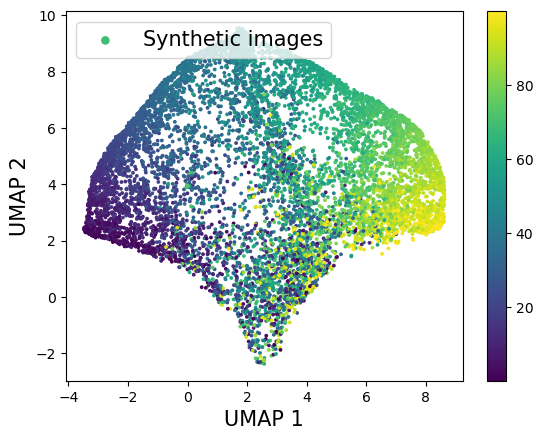

In [53]:
plt.scatter(
    embedding[:num_syn_parts, 0],
    embedding[:num_syn_parts, 1],
    s=3,
    c=indices,
    label="Synthetic images",
)
# plt.scatter(
#    embedding[num_syn_parts:, 0],
#    embedding[num_syn_parts:, 1],
#    s=1,
#    c=means,
#    label="Experimental images",
# )
plt.xlabel("UMAP 1", fontsize=15)
plt.ylabel("UMAP 2", fontsize=15)
plt.legend(fontsize=15, markerscale=3, loc="upper left")
plt.colorbar()

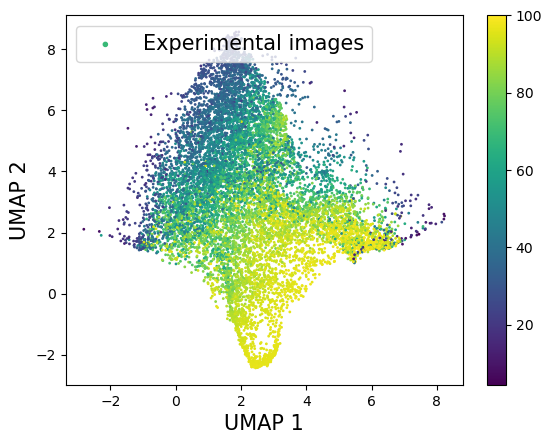

In [55]:
plt.scatter(
    embedding[num_syn_parts:, 0],
    embedding[num_syn_parts:, 1],
    s=1,
    c=confidence_widths,
    label="Experimental images",
)
plt.xlabel("UMAP 1", fontsize=15)
plt.ylabel("UMAP 2", fontsize=15)
plt.legend(fontsize=15, markerscale=3, loc="upper left")
plt.colorbar()

In [ ]:
# condition = np.sqrt(embedding[num_syn_parts:, 0] ** 2 + embedding[num_syn_parts:, 1] ** 2) < 5
# condition = embedding[num_syn_parts:, 0] > 12
condition = embedding[num_syn_parts:, 0] > 4
# condition = np.logical_and(embedding_exp[:, 0] > 7, embedding_exp[:, 0] < 8)
# condition = np.logical_and(embedding[:num_syn_parts, 0] < 10, embedding[:num_syn_parts, 1] > 12)
idx_almost_exp = np.where(condition)[0]
samples_almost = sample_posterior(
    estimator, particles_transfomed[idx_almost_exp], num_samples=10000, device="cuda"
)

In [ ]:
idx_almost_exp

In [ ]:
condition.sum()

In [ ]:
out_upper = (particles_latent < syntetic_particles_latent.max(dim=0).values).all(axis=1)
out_lower = (particles_latent > syntetic_particles_latent.min(dim=0).values).all(axis=1)
cond = torch.logical_and(out_lower, out_upper)
idx_almost_exp = torch.where(cond)[0]
# samples_almost = sample_posterior(estimator, particles_transfomed[idx_almost_exp], num_samples=10000, device='cuda')

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True)
for i, ax in enumerate(axes.reshape(1, -1)[0]):
    ax.hist(
        samples_almost[:, i].flatten().numpy(),
        bins=np.arange(0, 100, 2),
        histtype="step",
        color="blue",
        label="all",
    )
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks(range(0, 100, 20))
    # ax.axvline(60, color="red")

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(particles_transfomed[idx_almost_exp[i]], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(particles_transfomed[idx_almost_exp[i]], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(particles_transfomed[6], vmax=3, vmin=-3, cmap="binary")
axes[0].set_title("Resized real particle")
axes[1].imshow(images[15], vmax=3, vmin=-3, cmap="binary")
axes[1].set_title("Syntehtic particle")
# fig.savefig('../experiments/6wxb/results/plots/comparison_particles.pdf', dpi=400)

In [ ]:
vis_images = transform_vis(images)
vis_images_real = transform_vis1(
    "../../6wxb_test_particles/10532/data/03_Refined_Particles/P30_J363_particles/J342/localmotioncorrected/FoilHole_24136295_Data_24136362_24136364_20200224_020513_Fractions_particles_local_aligned.mrc"
)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(vis_images_real[43], vmax=3, vmin=-3, cmap="binary")
axes[0].set_title("Resized real particle")
axes[1].imshow(vis_images[51], vmax=3, vmin=-3, cmap="binary")
axes[1].set_title("Syntehtic particle")

In [ ]:
torch.fft.fft2(images[8])

In [ ]:
def circular_mask(n_pixels, radius, inside=True):
    grid = torch.linspace(-0.5 * (n_pixels - 1), 0.5 * (n_pixels - 1), n_pixels)
    r_2d = grid[None, :] ** 2 + grid[:, None] ** 2

    if inside is True:
        mask = r_2d < radius**2
    else:
        mask = r_2d > radius**2

    return mask

In [ ]:
import torch.distributions as d


class AddLowFrequencyNoise:
    """Adding low frequency noise, also serving as a low pass filter"""

    def __init__(self, image_size, min_frequency, amplitude) -> None:
        self._imge_size = image_size
        self._mask = circular_mask(image_size, min_frequency, inside=False)
        self._num_frequencies = self._mask.sum()

        if isinstance(amplitude, (float, int)):
            self._amplitude = d.uniform.Uniform(low=amplitude, high=amplitude)
        elif isinstance(amplitude, (list, tuple)):
            self._amplitude = d.uniform.Uniform(low=amplitude[0], high=amplitude[1])

    def __call__(self, image):
        fft_image = torch.fft.fft2(image)

        if len(image.shape) == 2:
            fft_image[self._mask] += self._amplitude.sample() * torch.randn(
                (self._num_frequencies,), dtype=torch.complex64
            )
            fft_image[self._mask == False] = 0 + 0j
        elif len(image.shape) == 3:
            fft_image[:, self._mask] += self._amplitude.sample(
                (image.shape[0], 1)
            ) * torch.randn(
                (image.shape[0], self._num_frequencies), dtype=torch.complex64
            )
            fft_image[:, self._mask == False] = 0 + 0j
        else:
            raise NotImplementedError

        return torch.fft.ifft2(fft_image).real

In [ ]:
d.uniform.Uniform(
    low=torch.tensor(1.0, device="cuda"), high=torch.tensor(1.0, device="cuda")
).sample((4,))

In [ ]:
cm = circular_mask(128, 80, inside=False)
cm2 = circular_mask(128, 50, inside=False)

In [ ]:
idx = 10

In [ ]:
fft_img = torch.fft.fft2(images[idx])
print(fft_img.real.max())
noise = fft_img.real.std() * 3.0 * torch.randn((cm.sum(),), dtype=torch.complex64)
# fft_img[cm] += noise
fft_img[cm2] = 0 + 0j

In [ ]:
ni = torch.fft.ifft2(fft_img).real

In [ ]:
images[:, cm2] = 0

In [ ]:
t = AddLowFrequencyNoise(128, 80, (0, 500))
images = t(images)

In [ ]:
torch.tensor([1,]).device = 

In [ ]:
plt.imshow(images[43], cmap="binary", vmax=2, vmin=-2)

In [ ]:
plt.imshow(ni, cmap="binary", vmax=2, vmin=-2)

In [ ]:
plt.imshow(particles_transfomed[43], cmap="binary", vmax=2, vmin=-2)

In [ ]:
cryosbi = CryoEmSimulator(data_dir + "image_params_mixed_training.json")
cryosbi.config["SNR"] = 0.1
cryosbi.config["SIGMA"] = 15.0
cryosbi.config["DEFOCUS"] = 1.0

In [ ]:
def gen_img(coord, image_params):
    n_atoms = coord.shape[1]

    if isinstance(image_params["SIGMA"], float):
        atom_sigma = image_params["SIGMA"]

    elif isinstance(image_params["SIGMA"], list) and len(image_params["SIGMA"]) == 2:
        atom_sigma = np.random.uniform(
            low=image_params["SIGMA"][0], high=image_params["SIGMA"][1]
        )
    else:
        raise ValueError(
            "SIGMA should be a single value or a list of [min_sigma, max_sigma]"
        )

    norm = 1 / (2 * torch.pi * atom_sigma**2 * n_atoms)

    grid_min = -image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
    grid_max = (
        image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
        + image_params["PIXEL_SIZE"]
    )

    grid = torch.arange(grid_min, grid_max, image_params["PIXEL_SIZE"])

    gauss_x = torch.exp(-0.5 * (((grid[:, None] - coord[0, :]) / atom_sigma) ** 2))

    gauss_y = torch.exp(-0.5 * (((grid[:, None] - coord[1, :]) / atom_sigma) ** 2))

    image = torch.matmul(gauss_x, gauss_y.T) * norm

    return image

In [ ]:
gen_img(cryosbi.models[0], cryosbi.config)

In [ ]:
%timeit gen_img(cryosbi.models[0], cryosbi.config)

In [ ]:
%timeit gen_img(cryosbi.models[0], cryosbi.config)

In [ ]:
mrc_to_tensor = MRCtoTensor()

In [ ]:
with mrcfile.open(
    "../../Simulation_example_RNApol_v2/highdose.mrc", permissive=True
) as mrc:
    particles = mrc.data

In [ ]:
plt.imshow(particles[3600:3800, 2800:3000], cmap="binary")

In [ ]:
plt.imshow(particles[1000:1128, 1000:1128], cmap="binary")